In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

plt.rcParams['figure.figsize'] = [12, 6]

import wandb
from wandb.keras import WandbCallback

In [2]:
time_point_ids = ["hhgat", "maput", "cntsq", "mit", "hynes", "masta", "Wasma", "Melwa", "Dudly"]
date_cols = ["service_date"] + time_point_ids

trip_data = pd.read_csv("../data/one_trips.csv",
                         index_col="half_trip_id", 
                         parse_dates = date_cols)
print(len(trip_data))
trip_data.head()

9078


,service_date,duration,hhgat,maput,cntsq,mit,hynes,masta,Wasma,Melwa,Dudly
half_trip_id,,,,,,,,,,,
46202752.0,2020-01-01,1913,1900-01-01 06:49:49,1900-01-01 06:53:22,1900-01-01 06:58:01,1900-01-01 07:01:52,1900-01-01 07:05:57,1900-01-01 07:12:25,1900-01-01 07:14:42,1900-01-01 07:20:57,1900-01-01 07:21:42
46202754.0,2020-01-01,1294,1900-01-01 07:49:34,1900-01-01 07:53:04,1900-01-01 07:55:01,1900-01-01 07:57:18,1900-01-01 07:59:36,1900-01-01 08:03:12,1900-01-01 08:06:34,1900-01-01 08:10:23,1900-01-01 08:11:08
46202756.0,2020-01-01,1625,1900-01-01 08:57:33,1900-01-01 09:01:42,1900-01-01 09:04:40,1900-01-01 09:09:07,1900-01-01 09:12:35,1900-01-01 09:14:51,1900-01-01 09:18:13,1900-01-01 09:23:52,1900-01-01 09:24:38
46202758.0,2020-01-01,1862,1900-01-01 10:19:20,1900-01-01 10:22:57,1900-01-01 10:26:10,1900-01-01 10:29:26,1900-01-01 10:33:48,1900-01-01 10:38:45,1900-01-01 10:44:08,1900-01-01 10:49:34,1900-01-01 10:50:22
46202760.0,2020-01-01,1935,1900-01-01 11:54:27,1900-01-01 11:59:07,1900-01-01 12:02:49,1900-01-01 12:07:55,1900-01-01 12:13:00,1900-01-01 12:17:51,1900-01-01 12:21:24,1900-01-01 12:26:08,1900-01-01 12:26:42


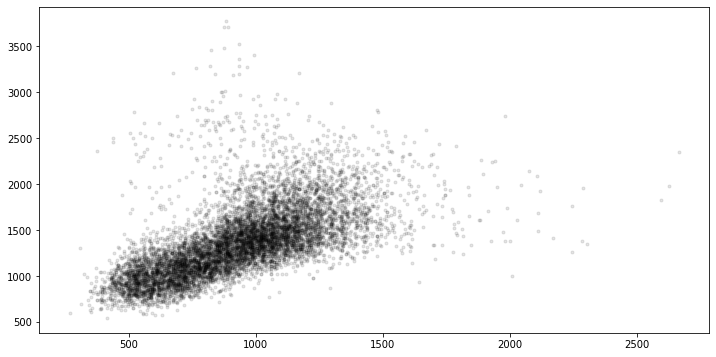

In [3]:
first_half = (trip_data.mit - trip_data.hhgat).dt.seconds
second_half = (trip_data.Dudly - trip_data.mit).dt.seconds
plt.plot(first_half, second_half, ".k", alpha=.1)

In [4]:
total_duration_df = pd.DataFrame({
    "weekday": (trip_data.service_date.dt.weekday < 5).astype('float'),
    "departure": (trip_data.hhgat - pd.to_datetime("1900-01-01")).dt.seconds,
    "duration": trip_data.duration
})
total_duration_df.head()

,weekday,departure,duration
half_trip_id,,,
46202752.0,1.0,24589,1913
46202754.0,1.0,28174,1294
46202756.0,1.0,32253,1625
46202758.0,1.0,37160,1862
46202760.0,1.0,42867,1935


In [5]:
def split_dataset(df, target_col, frac=.7, ):
    train = df.sample(frac=frac)
    test = df.loc[~df.index.isin(train.index)]

    y_train = train.pop(target_col).to_numpy()
    y_test = test.pop(target_col).to_numpy()
    
    x_train = train.to_numpy()
    x_test = test.to_numpy()
    
    return (x_train, y_train), (x_test, y_test)

In [6]:
from tensorflow.keras import layers

def make_model(preprocesser = None):
    
    model = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=1)
    ])
    
    if preprocesser is None:
        return model
    else:
        inputs = keras.Input(shape=(2,))
        x = preprocesser(inputs)
        outputs = model(x)
        return keras.Model(inputs, outputs)

make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [7]:
def get_preprocesser(features):    
    normalizer = layers.experimental.preprocessing.Normalization()
    normalizer.adapt(features)
    
    return normalizer

In [8]:
def run_duration_prediction(lr=1e-3, debug=False):
    if not debug:
        run = wandb.init(project='bus-predictions')

        config = wandb.config
        config.learning_rate = lr
    
    (x_train, y_train), (x_test, y_test) = split_dataset(total_duration_df, 'duration')
    
    model = make_model(preprocesser=get_preprocesser(x_train))
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), loss="mean_squared_error")
    
    history = None
    if debug:
        history = model.fit(x_train, y_train, epochs=5,  validation_data=(x_test, y_test), verbose=0)
    else:
        history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), verbose=0, callbacks=[WandbCallback()])

    predictions = model.predict(x_test)
    
    fig = plt.figure(figsize=(8,5))

    departures = x_test[:, 1]
    plt.plot(departures, predictions, ".k", alpha=.3)
    plt.plot(departures, y_test, ".g", alpha=.3)
    
    if debug:
        plt.show()
    else: 
        run.log({"predictions_by_time": wandb.Image(plt)})
        run.finish()

wandb: Currently logged in as: ngd (use `wandb login --relogin` to force relogin)


epoch,49
loss,214239.40625
val_loss,211992.09375
_runtime,40
_timestamp,1615473728
_step,50
best_val_loss,203818.07812
best_epoch,48


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


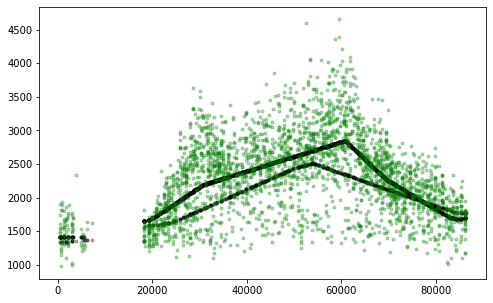

In [9]:
run_duration_prediction(debug=False)

# Second-half duration

## Scratch

In [ ]:
X = scaled_data[["cntsq", "headway"]]
y = scaled_data["delta"]


X_train, X_test, y_train, y_test = train_test_split(X, y)
regr = MLPRegressor(max_iter=10000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

In [ ]:
scaled_data = pd.DataFrame()

def normalize_time(times):
    start_time = pd.to_datetime("1900-01-01 05:00:00")
    end_time = pd.to_datetime("1900-01-02 03:00:00")
        
    return (times - start_time).dt.seconds / (end_time - start_time).seconds

scaled_data["cntsq"] = normalize_time(data.actual_cntsq)
scaled_data["headway"] = data.headway / 60*60
scaled_data["delta"] = data.delta / 60*20

scaled_data.head()

In [ ]:
regr.predict(X_test)

In [ ]:
results = pd.DataFrame()
results["prediction"] = regr.predict(X_test)
results["actual"] = y_test.values

plt.plot(results.prediction, results.actual, ".k", alpha=.3)